In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

2025-05-24 00:52:14.881027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748026335.005803    8153 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748026335.036724    8153 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748026335.302705    8153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748026335.302723    8153 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748026335.302724    8153 computation_placer.cc:177] computation placer alr

In [2]:
train_path= '/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/train'
val_path='/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/val'
test_path='/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen= image.ImageDataGenerator()

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=False,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=False,
    class_mode = 'categorical'
)

Found 20263 images belonging to 8 classes.
Found 2540 images belonging to 8 classes.
Found 2557 images belonging to 8 classes.


In [5]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(class_names)

['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


In [6]:
image_size = (224, 224)
batch_size = 8

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.image.convert_image_dtype(img, tf.float32) / 255.0
    return img

# Function to get image paths and labels from a directory
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your file types
                image_paths.append(os.path.join(class_path, filename))
                labels.append(class_indices[class_name])
    return image_paths, tf.one_hot(labels, depth=len(class_names)) # One-hot encode labels

# Create training dataset
train_image_paths, train_labels = get_image_paths_and_labels(train_path)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(lambda path, label: (load_and_preprocess_image(path), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create validation dataset
validation_image_paths, validation_labels = get_image_paths_and_labels(test_path)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_labels))
validation_dataset = validation_dataset.map(lambda path, label: (load_and_preprocess_image(path), label),
                                           num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1748026339.251926    8153 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5511 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
from tensorflow.keras import Sequential, layers

# Load the pre-trained EfficientNetB3 model (excluding the top classification layer)
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Create a new sequential model
model = Sequential()

# Add the EfficientNetB3 base model
model.add(base_model)

# Add the convolutional layers you defined
# model.add(layers.Conv2D(filters=8, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool2D(pool_size=(3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))

# Print the model summary
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       802,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,367,624 (92.96 MB)

 Trainable params: 24,322,184 (92.78 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    epochs=50,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')],
    validation_data=validation_generator
    )

Epoch 1/50


/home/nemo/.conda/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748026385.672704    8316 service.cc:152] XLA service 0x74d990003040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748026385.672724    8316 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-05-24 00:53:06.810203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748026389.411845    8316 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-24 00:53:31.631241: I external/local_x

2533/2533 ━━━━━━━━━━━━━━━━━━━━ 343s 119ms/step - accuracy: 0.3085 - loss: 2.7339 - val_accuracy: 0.3610 - val_loss: 1.9678 - learning_rate: 0.0010
Epoch 2/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 260s 103ms/step - accuracy: 0.4474 - loss: 1.2541 - val_accuracy: 0.3705 - val_loss: 1.4724 - learning_rate: 0.0010
Epoch 3/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 258s 102ms/step - accuracy: 0.6207 - loss: 0.9024 - val_accuracy: 0.3555 - val_loss: 3.1077 - learning_rate: 0.0010
Epoch 4/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 255s 101ms/step - accuracy: 0.7210 - loss: 0.7052 - val_accuracy: 0.5453 - val_loss: 1.6602 - learning_rate: 0.0010
Epoch 5/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 267s 105ms/step - accuracy: 0.7828 - loss: 0.5646 - val_accuracy: 0.7193 - val_loss: 0.8369 - learning_rate: 0.0010
Epoch 6/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 270s 107ms/step - accuracy: 0.8376 - loss: 0.4608 - val_accuracy: 0.7307 - val_loss: 0.7382 - learning_rate: 0.0010
Epoch 7/50
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 269s 106ms/step - acc

In [10]:
model.save('all_models/ResNet50V2.keras')

In [11]:
model.evaluate(test_generator)

320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9774 - loss: 0.0637


[0.07993199676275253, 0.9734063148498535]

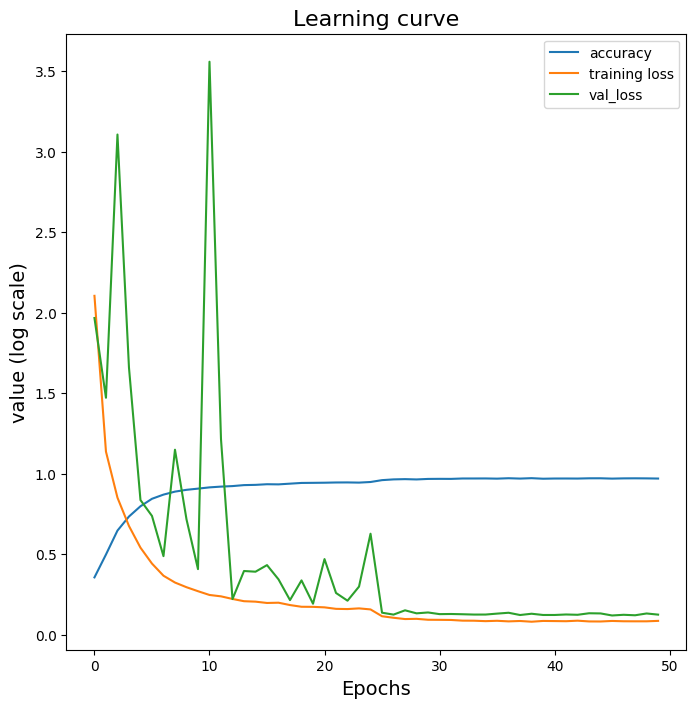

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve", fontsize=16)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend()
plt.savefig('learning_curve.pdf')

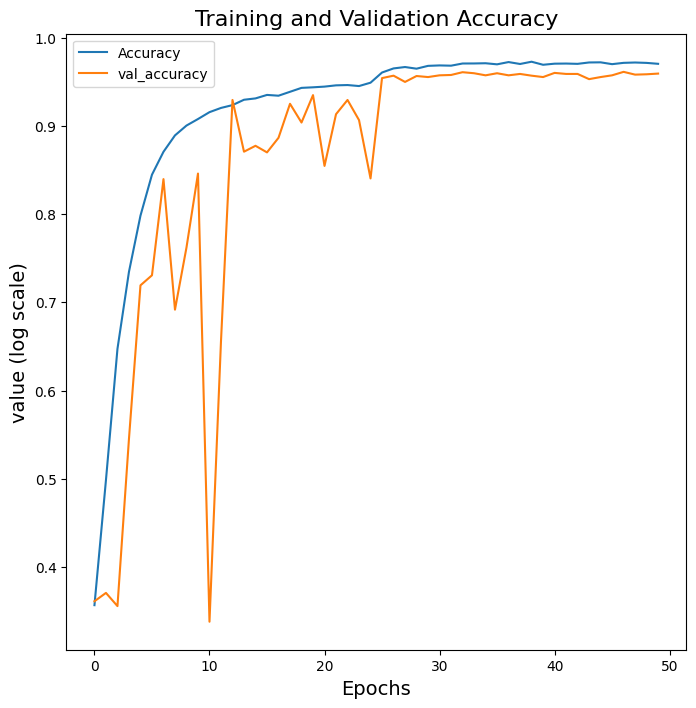

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Accuracy", fontsize=16)
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('accuracy_curve.pdf')

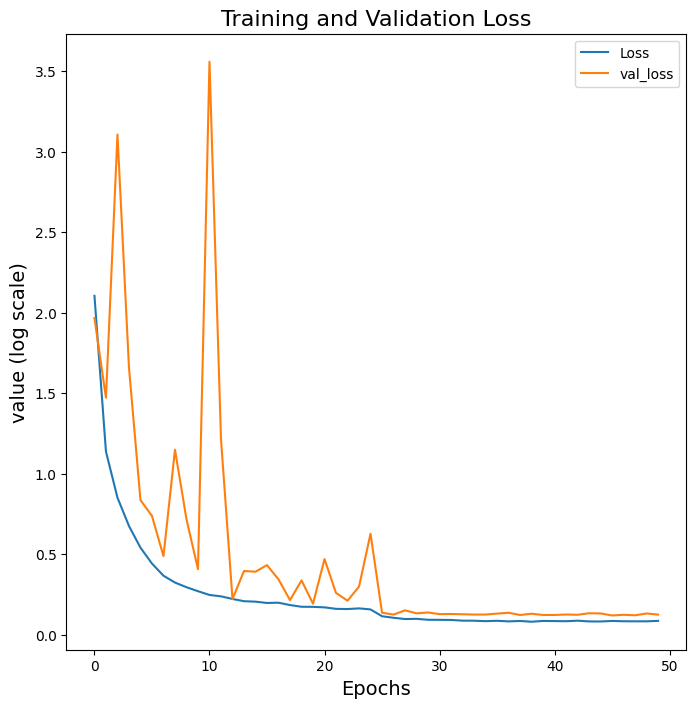

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Loss", fontsize=16)
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('loss_curve.pdf')

KeyError: 'Precision'

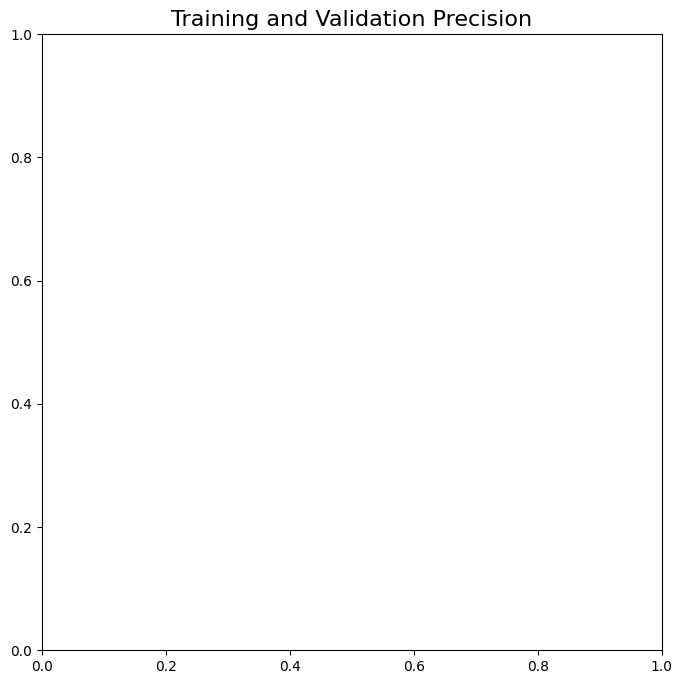

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Precision", fontsize=16)
plt.plot(history.history["Precision"], label="precision")
plt.plot(history.history["val_Precision"], label="val_precision")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('precision_curve.pdf')

KeyError: 'Recall'

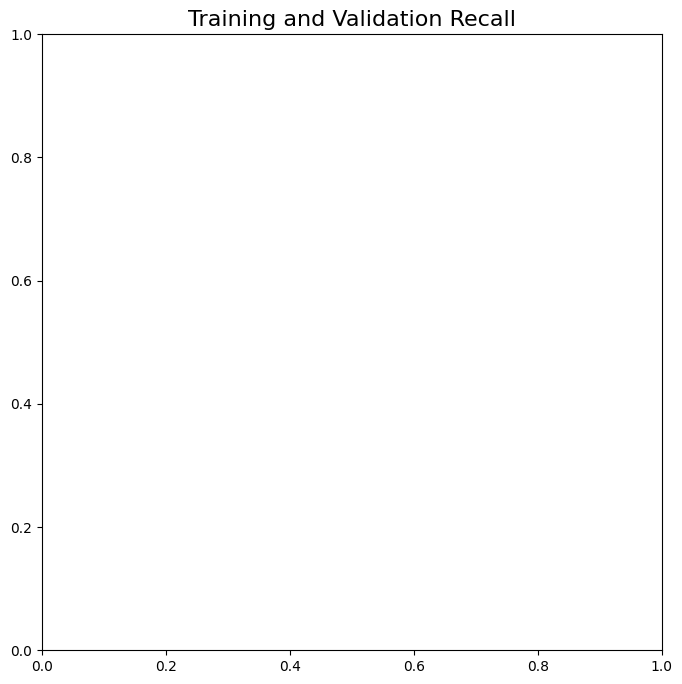

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Recall", fontsize=16)
plt.plot(history.history["Recall"], label="recall")
plt.plot(history.history["val_Recall"], label="val_recall")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('recall_curve.pdf')

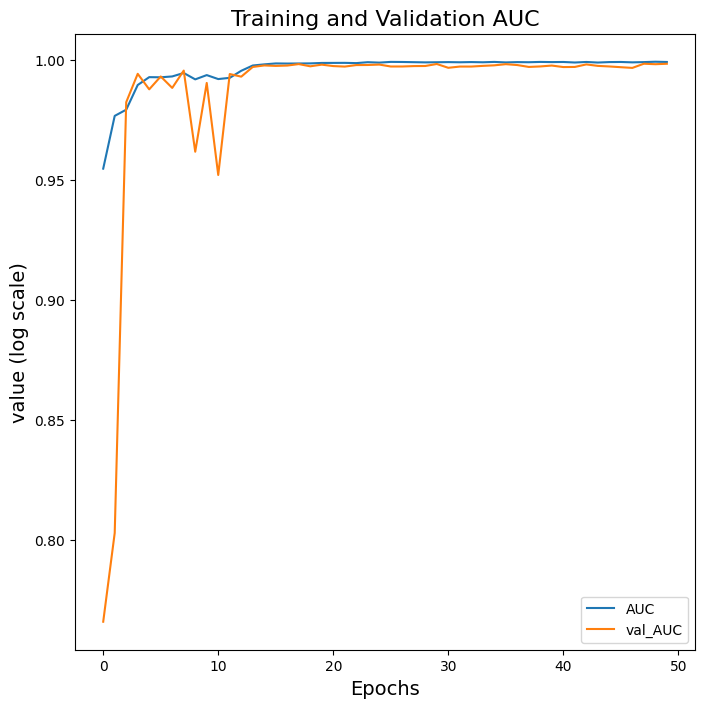

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation AUC", fontsize=16)
plt.plot(history.history["AUC"], label="AUC")
plt.plot(history.history["val_AUC"], label="val_AUC")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('auc_curve.pdf')

In [19]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step


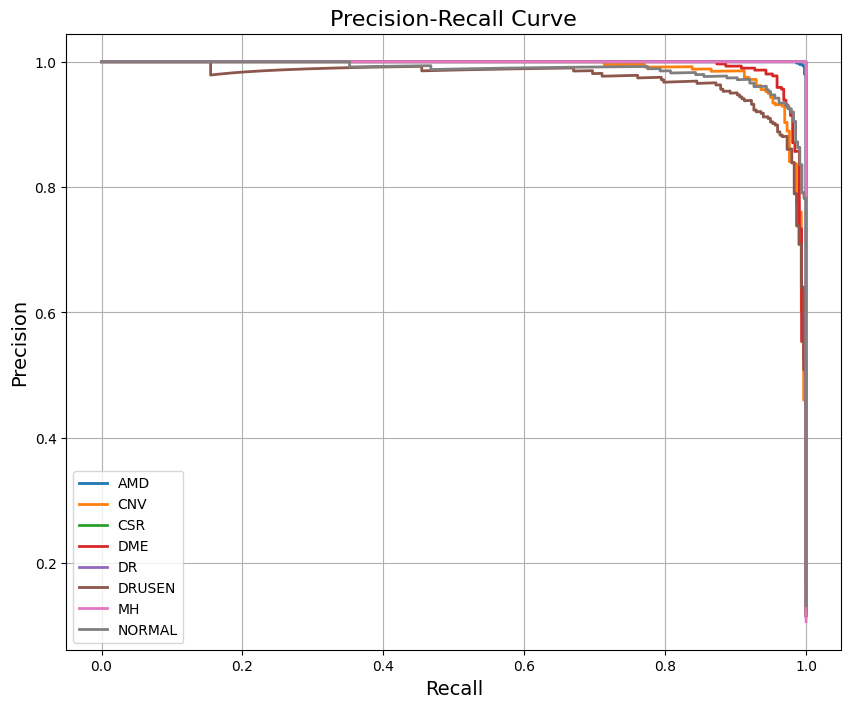

In [20]:
# Binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('precision_recall_curve.pdf')
plt.show()

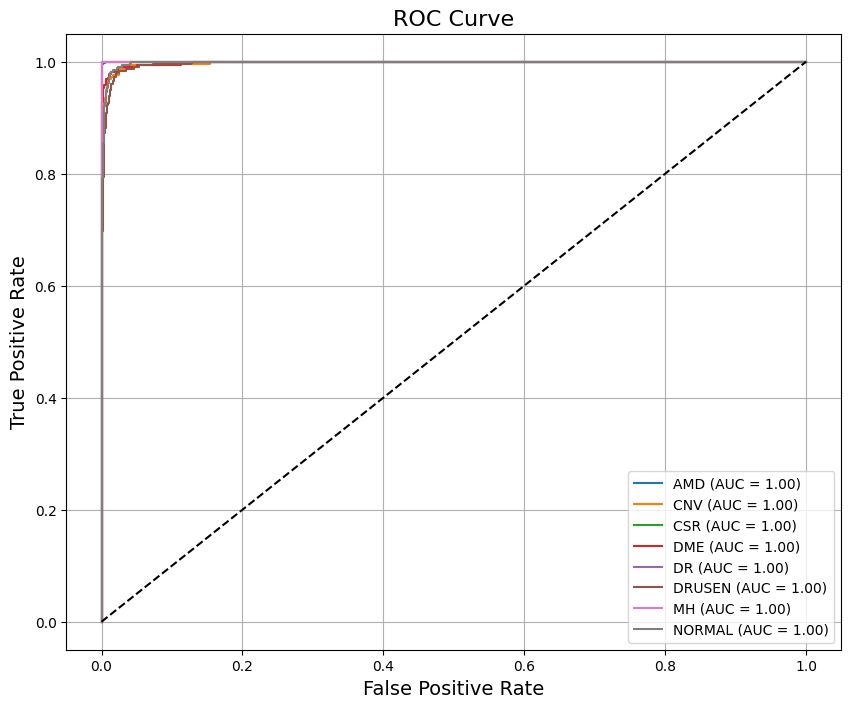

In [21]:
# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.grid()
plt.savefig('roc_curve.pdf')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[3.0231165e-06 2.4799803e-07 9.9999475e-01 4.0410213e-09 1.7628706e-06
  3.3832555e-11 2.9071902e-07 2.1865885e-09]]
THE UPLOADED OCT IMAGE IS: CSR


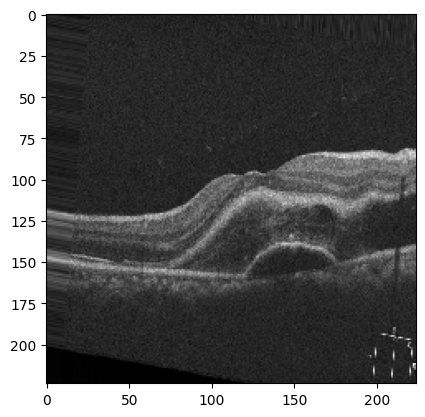

In [22]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test/CSR/csr_train_2348.jpg',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,axis=1)
if a==0:
      op="AMD"   
elif a==1:
    op='CNV'
elif a==2:
    op='CSR'
elif a==3:
    op='DME'
elif a==4:
    op='DR'
elif a==5:
    op='DRUSEN'
elif a==6:
    op='MH'
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED OCT IMAGE IS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[2.0034378e-02 5.6536703e-07 2.6953083e-07 6.3441414e-04 3.0388833e-08
  8.5020347e-06 9.2840287e-09 9.7932190e-01]]
THE UPLOADED OCT IMAGE IS: Normal


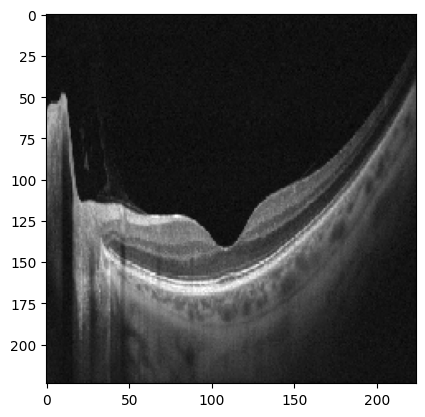

In [23]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test/NORMAL/no_2497093_3.jpg',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,axis=1)
if a==0:
      op="AMD"   
elif a==1:
    op='CNV'
elif a==2:
    op='CSR'
elif a==3:
    op='DME'
elif a==4:
    op='DR'
elif a==5:
    op='DRUSEN'
elif a==6:
    op='MH'
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED OCT IMAGE IS: "+str(op))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
# Get true labels
y_true = validation_generator.classes

# Predict probabilities
y_pred_prob = model.predict(validation_generator)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)


318/318 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step


In [26]:
class_labels = list(validation_generator.class_indices.keys())

In [27]:
cm = confusion_matrix(y_true, y_pred)

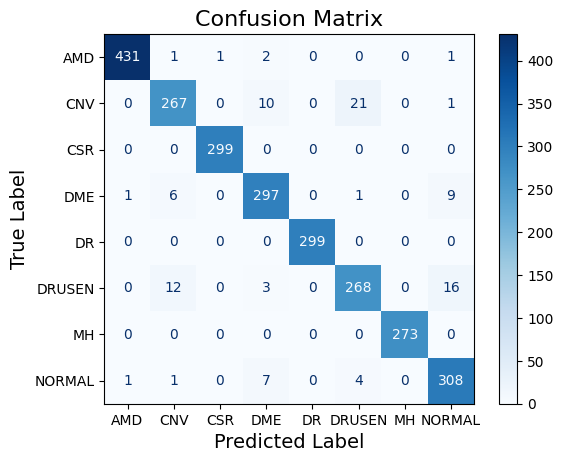

<Figure size 640x480 with 0 Axes>

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()
plt.savefig('confusion_matrix.pdf')

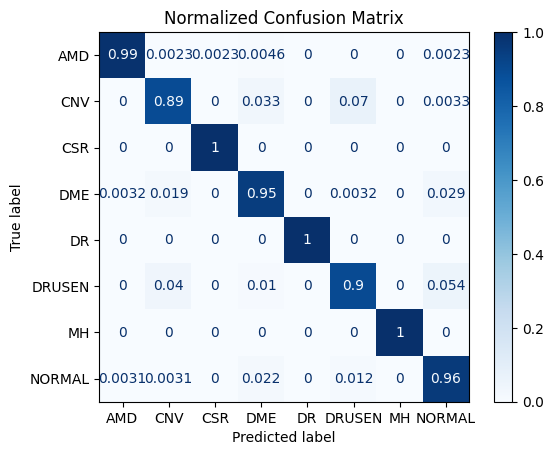

In [29]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.show()

In [30]:
from sklearn.metrics import classification_report


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         AMD       1.00      0.99      0.99       436
         CNV       0.93      0.89      0.91       299
         CSR       1.00      1.00      1.00       299
         DME       0.93      0.95      0.94       314
          DR       1.00      1.00      1.00       299
      DRUSEN       0.91      0.90      0.90       299
          MH       1.00      1.00      1.00       273
      NORMAL       0.92      0.96      0.94       321

    accuracy                           0.96      2540
   macro avg       0.96      0.96      0.96      2540
weighted avg       0.96      0.96      0.96      2540



## Inference Time

In [31]:
import time
import numpy as np

# Assuming 'model' is your trained Keras model
# Assuming 'test_generator' or a similar data source is available

# --- Prepare your inference data ---
# Get one batch for inference timing.
# Make sure test_generator is properly initialized and can yield a batch.
# If your generator shuffles, reset it for consistent batch content if needed.
test_generator.reset()
X_inference_batch, _ = next(test_generator) # Use next() to get a single batch

print(f"Shape of inference batch: {X_inference_batch.shape}")
print(f"Batch size: {X_inference_batch.shape[0]}")

# --- 1. Warm-up runs (recommended) ---
print("\nPerforming warm-up runs...")
for _ in range(5): # Run 5 warm-up predictions
    _ = model.predict(X_inference_batch, verbose=0)
print("Warm-up complete.")

# --- 2. Measure inference time for a single batch (per step) ---
num_measurements = 100 # Number of times to repeat the measurement for averaging
inference_times_sec_per_step = []

print(f"\nMeasuring inference time over {num_measurements} repetitions...")
for _ in range(num_measurements):
    start_time = time.time()
    _ = model.predict(X_inference_batch, verbose=0) # Set verbose=0 to suppress progress bar
    end_time = time.time()
    inference_times_sec_per_step.append(end_time - start_time)

# Calculate average time per step in seconds
average_inference_time_sec_per_step = np.mean(inference_times_sec_per_step)
std_inference_time_sec_per_step = np.std(inference_times_sec_per_step)

# Convert to milliseconds per step
average_inference_time_ms_per_step = average_inference_time_sec_per_step * 1000
std_inference_time_ms_per_step = std_inference_time_sec_per_step * 1000

print(f"\nAverage inference time per step (batch size {X_inference_batch.shape[0]}):")
print(f"  {average_inference_time_ms_per_step:.4f} ms/step (Std Dev: {std_inference_time_ms_per_step:.4f} ms/step)")

# Optional: Calculate ms/sample if desired
samples_in_batch = X_inference_batch.shape[0]
if samples_in_batch > 0:
    average_inference_time_ms_per_sample = average_inference_time_ms_per_step / samples_in_batch
    print(f"  {average_inference_time_ms_per_sample:.4f} ms/sample")

# --- Example for total inference time over the whole test set ---
# If you want to know the ms/step for the entire generator, you would need to
# divide the total inference time by the number of steps (batches) in the generator.

print("\nMeasuring total inference time for the entire test set...")
test_generator.reset() # Reset generator for a full pass
num_test_steps = len(test_generator) # Get the total number of batches

overall_inference_start_time = time.time()
_ = model.predict(test_generator, verbose=1) # verbose=1 to see progress
overall_inference_end_time = time.time()

total_test_inference_time_sec = overall_inference_end_time - overall_inference_start_time
total_test_inference_time_ms = total_test_inference_time_sec * 1000

# Calculate average ms/step for the entire test set pass
if num_test_steps > 0:
    average_ms_per_step_full_pass = total_test_inference_time_ms / num_test_steps
    print(f"Total inference time for test set: {total_test_inference_time_ms:.2f} ms")
    print(f"Average ms/step over entire test set ({num_test_steps} steps): {average_ms_per_step_full_pass:.4f} ms/step")
else:
    print("test generator has no steps.")

Shape of inference batch: (8, 224, 224, 3)
Batch size: 8

Performing warm-up runs...
Warm-up complete.

Measuring inference time over 100 repetitions...

Average inference time per step (batch size 8):
  68.9271 ms/step (Std Dev: 2.2909 ms/step)
  8.6159 ms/sample

Measuring total inference time for the entire test set...
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Total inference time for test set: 6929.33 ms
Average ms/step over entire test set (320 steps): 21.6541 ms/step


In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [33]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 2533}

In [34]:
print(tf.__version__)

2.19.0


In [35]:
print(tf.keras.__version__)

3.9.2
